In [1]:
import time
import torch

from torch import nn, Tensor
from torch.utils.data import DataLoader, TensorDataset

import flow_matching
from flow_matching.path.scheduler import CondOTScheduler
from flow_matching.path import AffineProbPath
from flow_matching.solver import Solver, ODESolver
from flow_matching.utils import ModelWrapper
from Distributions2 import *
# visualization
import matplotlib.pyplot as plt

from matplotlib import cm
from flow import build_ttf_m
from network import MLP

# To avoide meshgrid warning
import warnings

warnings.filterwarnings("ignore", category=UserWarning, module='torch')

In [2]:
if torch.cuda.is_available():
    device = 'cuda:0'
    print('Using gpu')
else:
    device = 'cpu'
    print('Using cpu.')
torch.manual_seed(42)
seed=42

Using gpu


## Sampling data

In [3]:
#PRINT MIX OF STUDENT-T
dof_og=1
ST_DATA,objectz=samplestudentT_4(50,dof_og,40000)
# plt.scatter(ST_DATA[:,0],ST_DATA[:,1],c="blue")

In [4]:
#GETTING THE Data split and TAIL INDEX ESTIMATES
from generate_splits import generate_data_split
from Distributions2 import sample_stdentt



In [5]:
Data_Splt=generate_data_split('gppg', seed, 'dummy',ST_DATA)


  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:53<00:00, 26.96s/it]


In [6]:
Data_Splt['metadata']

{'dfs': [0.9689141215408199, 0.9461591723366531],
 'pos_dfs': [0.0, 1.0584125863547804],
 'neg_dfs': [0.7025663869297953, 0.870418293978243],
 'mean': [-2.426814, -0.6382829],
 'std': [350.42422, 127.15294],
 'seed': 42}

## Building the Tail Model

In [7]:
# def ttf_rqs(dim, dfs):
#     return flows.build_ttf_m(
#         dim,
#         model_kwargs=dict(
#             fix_tails=False,
#             pos_tail_init=[
#                 float(t.cpu()) for t in torch.distributions.Uniform(low=0.05, high=1.0).sample([dim])
#             ],
#             neg_tail_init=[
#                 float(t.cpu()) for t in torch.distributions.Uniform(low=0.05, high=1.0).sample([dim])
#             ]
#         )
#     )


# def ttf_rqs_fix(dim, dfs):
#     return build_ttf_m(
#         dim,
#         model_kwargs=dict(
#             fix_tails=False,#ADITYA CHANGED THIS
#             pos_tail_init=[1 / df if df != 0.0 else 1e-4 for df in dfs['metadata']['pos_dfs']],  #DIFFFERENT FROM MAIN CODE
#             neg_tail_init=[1 / df if df != 0.0 else 1e-4 for df in dfs['metadata']['neg_dfs']],  #DIFFFERENT FROM MAIN CODE
#         )
#     )

In [8]:
# list(ttf_rqs_fix(2,Data_Splt).parameters())


In [9]:
# training arguments
lr = 0.001
batch_size = 4096
iterations = 800
print_every = 1
hidden_dim = 512
dimension=2
device
# velocity field model init
vf = MLP(input_dim=2, time_dim=1, hidden_dim=hidden_dim).to(device)
# data2noiseTransform=ttf_rqs_fix(dimension,Data_Splt).to(device)


In [10]:
# list(data2noiseTransform.parameters())
# data2noiseTransform(torch.randn(22,2).to(device))[0].shape

In [11]:
trn_ix = Data_Splt["split"]["trn"]
val_ix = Data_Splt["split"]["val"]
tst_ix = Data_Splt["split"]["tst"]

mean = torch.tensor(Data_Splt['metadata']["mean"])
scale = torch.tensor(Data_Splt['metadata']["std"])

x_trn =ST_DATA[trn_ix] #(ST_DATA[trn_ix] - mean) / scale
x_val =ST_DATA[val_ix] #(ST_DATA[val_ix] - mean) / scale
x_tst =ST_DATA[tst_ix] #(ST_DATA[tst_ix] - mean) / scale

In [12]:
# def reverse_normalization(x):
#     y=(x*scale)+mean
#     return(y)
    

In [13]:
train_dataset = TensorDataset(x_trn)


# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [14]:
jo=0 #counter
# instantiate an affine path object
path = AffineProbPath(scheduler=CondOTScheduler())

# init optimizer
optim = torch.optim.Adam(vf.parameters(), lr=lr/10)
# optim2=torch.optim.Adam(data2noiseTransform.parameters(), lr=lr)
# train
start_time = time.time()
for i in range(iterations):
    for data in train_loader:
        optim.zero_grad()
        # optim2.zero_grad()
        # sample data : in this case, (X_0,X_1) ~ pi(X_0,X_1) = N(X_0|0,I)q(X_1)
        # print(data[0].shape)
        x_1_H=data[0].float().to(device)
        x_0,ob =sample_stdentt([0,0],[[1,0],[0,1]],Data_Splt['metadata']['dfs'][0],x_1_H.shape[0]) #torch.randn_like(x_1_H).float().to(device)
        x_0=x_0.float().to(device)
        x_1=x_1_H#data2noiseTransform(x_1_H)[0] #Heavy tail to light tail
       


        # sample time 
        t = torch.rand(x_1.shape[0]).to(device)

        # sample probability path
        path_sample = path.sample(t=t, x_0=x_0, x_1=x_1)
        # print(vf(path_sample.x_t,path_sample.t))

        # flow matching l2 loss
        
        loss = torch.pow( vf(path_sample.x_t,path_sample.t) - path_sample.dx_t, 2).mean()

        # optimizer step
        loss.backward() # backward
        optim.step() # update
        # optim2.step()

    # log loss
        jo=jo+1
        if (jo+1) % print_every == 0:
            elapsed = time.time() - start_time
            print('| iter {:6d} | {:5.2f} ms/step | loss {:8.3f} '
                .format(jo+1, elapsed*1000/print_every, loss.item()))
            start_time = time.time()

| iter      2 | 3670.36 ms/step | loss 28061.549 
| iter      3 | 31.02 ms/step | loss 13255.014 
| iter      4 | 25.02 ms/step | loss 365664.406 
| iter      5 | 26.01 ms/step | loss 14280.035 
| iter      6 | 24.01 ms/step | loss 9272.260 
| iter      7 | 26.01 ms/step | loss 92257.359 
| iter      8 | 298.07 ms/step | loss 34866.219 
| iter      9 | 25.01 ms/step | loss 408940.469 
| iter     10 | 28.01 ms/step | loss 8436.281 
| iter     11 | 25.01 ms/step | loss 5515.882 
| iter     12 | 28.01 ms/step | loss 27923.156 
| iter     13 | 26.01 ms/step | loss 20668138.000 
| iter     14 | 30.99 ms/step | loss 16347.607 
| iter     15 | 28.01 ms/step | loss 24963.125 
| iter     16 | 25.01 ms/step | loss 6679.527 
| iter     17 | 24.01 ms/step | loss 386260.625 
| iter     18 | 24.01 ms/step | loss 34073.270 
| iter     19 | 171.04 ms/step | loss 375107.656 
| iter     20 | 25.01 ms/step | loss 7430.273 
| iter     21 | 22.00 ms/step | loss 9719.587 
| iter     22 | 27.01 ms/step | los

In [15]:
class WrappedModel(ModelWrapper):
    def forward(self, x: torch.Tensor, t: torch.Tensor, **extras):
        return self.model(x, t)

wrapped_vf = WrappedModel(vf)

In [29]:
# step size for ode solver
step_size = 0.05

norm = cm.colors.Normalize(vmax=50, vmin=0)

batch_size = 10000  # batch size
eps_time = 1e-2
T = torch.linspace(0,1,10)  # sample times
T = T.to(device=device)

x_init,ob = sample_stdentt([0,0],[[1,0],[0,1]],Data_Splt['metadata']['dfs'][0],batch_size) #torch.randn((batch_size, 2), dtype=torch.float32, device=device)
x_init=x_init.to(device)
solver = ODESolver(velocity_model=wrapped_vf)  # create an ODESolver class
sol = solver.sample(time_grid=T, x_init=x_init, method='midpoint', step_size=step_size, return_intermediates=True)  # sample from the model


In [30]:
for i in range(10):
    # sol[i]=reverse_normalization(data2noiseTransform.inverse(torch.tensor(sol[i]).to(device))[0].detach().cpu())
    sol[i]=sol[i].to('cpu')
    # sol = sol.cpu().numpy()
T = T.cpu()
# sol[i].cpu()

In [18]:
(sol[9]).max()

tensor(1369.0267, device='cuda:0')

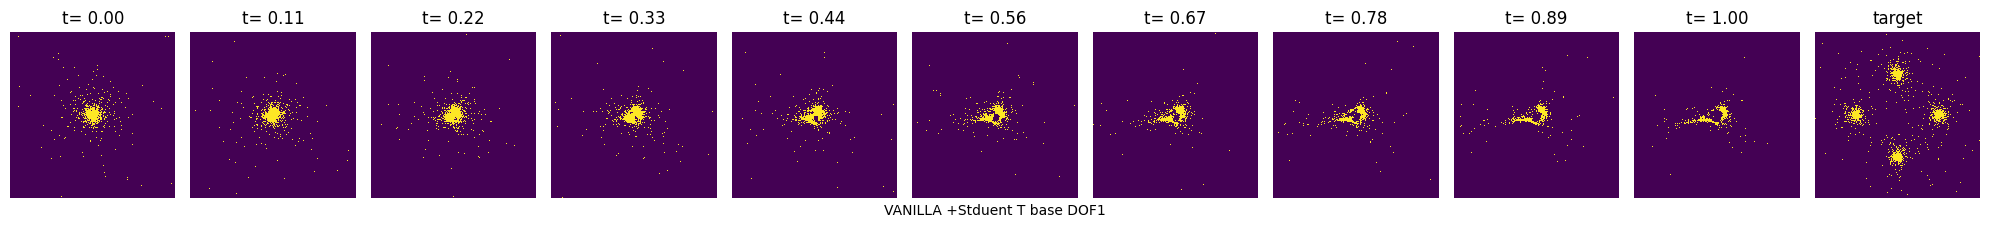

In [32]:
#VISUALIZE PATH

RR=100
fig, axs = plt.subplots(1, 11,figsize=(20,20))

for i in range(11):
    # H= axs[i].hist2d(sol[i,:,0].cpu(), sol[i,:,1].cpu(), 300, range=((-1*RR,RR), (-1*RR,RR)))

    cmin = 0.0
    cmax = 0.99#torch.quantile(torch.from_numpy(H[0]), 0.99).item()

    norm = cm.colors.Normalize(vmax=cmax, vmin=cmin)
    #data2noiseTransform.inverse(torch.tensor(sol[i]).to(device))[0].detach().cpu()
    # print(img.shape)
    if i==10:
        img=x_tst
        _ = axs[i].hist2d(img[:,0].cpu(), img[:,1].cpu(), 300, range=((-1*RR,RR), (-1*RR,RR)), norm=norm)

    else:
        img=sol[i]
        _ = axs[i].hist2d(img[:,0].cpu(), img[:,1].cpu(), 300, range=((-1*RR,RR), (-1*RR,RR)), norm=norm)

    axs[i].set_aspect('equal')
    axs[i].axis('off')
    if i==10:
        axs[i].set_title('target')
    else:
        axs[i].set_title('t= %.2f' % (T[i]))

plt.tight_layout()
fig.text(0.5, 0.45, 'VANILLA +Stduent T base DOF'+str(dof_og), ha='center')
plt.show()

In [20]:
# sample with likelihood

T = torch.tensor([1., 0.])  # sample times
T = T.to(device=device)

# grid_size = 200
# x_1 = torch.meshgrid(torch.linspace(-60, 60, grid_size), torch.linspace(-60, 60, grid_size))
# x_1 = torch.stack([x_1[0].flatten(), x_1[1].flatten()], dim=1).to(device)
x_1=x_tst[0:1000,:].to(device)
print(x_1.shape)

torch.Size([1000, 2])


In [21]:
# from torch.autograd.functional import jacobian
from torch.distributions import Independent, Normal

In [22]:
# def noise2data_and_reverse_norm(x): #Beware we want likelihood in the space of the actual distribution
#     return(reverse_normalization(data2noiseTransform.inverse(x)[0])) 

# mean=mean.to(device)
# scale=scale.to(device)

In [23]:
#  noise2data_and_reverse_norm(x_1).shape
ob

MultivariateStudentT(df: 0.9689141511917114, loc: torch.Size([2]), scale_tril: torch.Size([2, 2]))

In [24]:
S1,ob1=sample_stdentt(torch.tensor([0,0]).to(device),torch.tensor([[1,0],[0,1]]).to(device),torch.tensor(Data_Splt['metadata']['dfs'][0]).to(device),2)

c:\Users\adity\OneDrive\Desktop\mscThesis\Code3\Thesis_FLow\Distributions2.py:146: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ob=MultivariateStudentT(torch.tensor(df).float(),torch.tensor(m).float(),torch.tensor(S).float())


In [25]:
# from functorch import vmap, jacrev
# source distribution is an isotropic gaussian
st_log_density = ob1.log_prob#Independent(Normal(torch.zeros(2, device=device), torch.ones(2, device=device)), 1).log_prob

# compute log likelihood with unbiased hutchinson estimator, average over num_acc
num_acc = 10
log_p_acc = 0

for i in range(num_acc):
    _, log_p = solver.compute_likelihood(x_1=x_1, method='midpoint', step_size=step_size, exact_divergence=False, log_p0=st_log_density)
    # jacobian = jacrev(noise2data_and_reverse_norm)  # Differentiate param wrt t
    # jacobian_term = vmap(jacobian)(data2noiseTransform(x_1)[0]) 
    # jacobian_term=jacobian(noise2data_and_reverse_norm,data2noiseTransform(x_1)[0]) 
    # print(jacobian_term.mean())
    correct_log_p=log_p#-torch.log(0.000001+torch.abs(torch.linalg.det(jacobian_term)))  #MUST CHECCK AGAIN

    log_p_acc += correct_log_p

log_p_acc /= num_acc

# compute with exact divergence not the hutchinson estimator
# _, exact_log_p = solver.compute_likelihood(x_1=x_1, method='midpoint', step_size=step_size, exact_divergence=True, log_p0=gaussian_log_density)

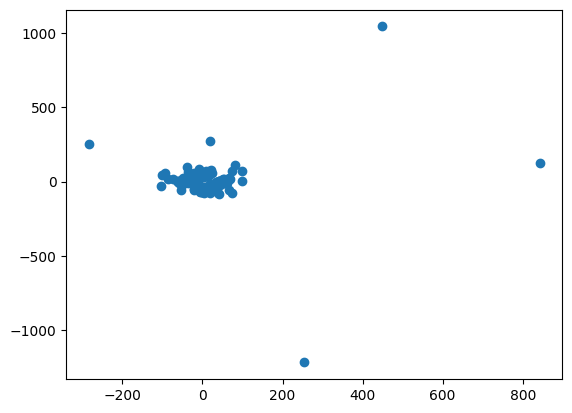

In [28]:
plt.scatter(x_1[:,0].cpu(),x_1[:,1].cpu())

In [26]:
print("Loglikelihood",log_p_acc.mean())


Loglikelihood tensor(-14.8096, device='cuda:0')
